In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm.notebook import tqdm, trange
import torch
import autograd.numpy as np
import autograd.scipy.stats as stats
import scipy.optimize as optimize
from autograd.scipy.linalg import logm
from autograd import grad, jacobian, hessian
import numpy
import scipy
import pandas as pd
import ipywidgets as widgets
import time
from sklearn import linear_model

In [3]:
def decode_q_params(encoded_q):
        shape = len(encoded_q)
        mean_shape = 3
        A_shape = (int(np.sqrt(shape - mean_shape)), int(np.sqrt(shape - mean_shape)))
        mean = encoded_q[0:mean_shape]
        A = encoded_q[mean_shape:shape].reshape(A_shape)
        return mean, A
    
def encode_q_params(q_params):
    mean, A = q_params
    return np.array(list(mean) + list(A.flatten()))

def augment_d(d):
    return np.concatenate((d.T, [np.ones(len(d))]), axis=0).T

In [6]:
def optimizer(x0, gradient, callback=lambda x, g: True, rate=1, decay=0.5, iters=1e1, label=None, leave=True, thres=0.1):
    x = x0
    for i in tqdm(range(int(iters)), desc=label, leave=leave):
        r = rate * 1/(10+i*decay)
        g = gradient(x)
        x = -g * r + x
        if not callback(x, g):
            break
    return x

In [15]:
def log_pdf(x, mean, cov):
    n = cov.shape[-1]
    _, log_det = np.linalg.slogdet(cov)
    return -0.5*(n * np.log(2 * np.pi) + log_det + (x - mean).T @ np.linalg.inv(cov) @ (x - mean))

In [221]:
def KLD(mean_q, A_q, mean_p, A_p):
    sigma_q = (A_q @ A_q.T)
    sigma_p = (A_p @ A_p.T)
    bar_sigma_q = np.linalg.norm(sigma_q)
    bar_sigma_p = np.linalg.norm(sigma_p)
    k = len(mean_q)
    return 0.5 * (np.trace(np.linalg.inv(sigma_p) @ sigma_q) + (mean_p - mean_q).T @ np.linalg.inv(sigma_p) @ (mean_p - mean_q) - k + np.log(bar_sigma_p/bar_sigma_q))

def ELBO(d, y, mean, A): # optimizing for mean, A
    N = 10
    zs = np.random.normal(size=(N, len(mean))) # N samples of size d
    likelihood_samples = []
    for z in zs:
        theta = mean + A @ z
        likelihood_samples.append(log_likelihood(y, theta, d))
    return 1/N * np.sum(likelihood_samples, axis=0) - KLD(mean, A, prior_mean, prior_A)
def log_likelihood(y, theta, d):
    return log_pdf(y, d @ theta, noise * np.eye(len(y)))

In [222]:
stats.multivariate_normal.logpdf(np.array([1,1]), np.array([1,1]), np.eye(2))
log_pdf(np.array([1,1]), np.array([1,1]), np.eye(2))

-1.8378770664093453

In [236]:
d = np.random.randn(100,2)
prior_A = np.array([[5, -2, 1],
              [-2, 4, -1],
              [1, -1, 3]])
#prior_A = np.eye(3)
prior_mean = np.array([7, -4, 1])
noise = 0.8
true_weights = np.array([18, -1, -15])
y = (augment_d(d) @ np.array([true_weights]).T + np.random.randn() * noise).T[0]
mu0 = prior_mean
A0 = prior_A
def objective_f(encoded_q_params):
    mean, A = decode_q_params(encoded_q_params)
    elbo = ELBO(augment_d(d), y, mean, A)
    elbos.append(elbo._value)
    return -elbo

In [241]:
qs = []
elbos = []
optimizer(encode_q_params((mu0, A0)), grad(objective_f), iters=5e2, callback=callback, rate=1e-3, decay=1e-5)

  0%|          | 0/500 [00:00<?, ?it/s]

array([ 1.79350992e+01, -1.02016706e+00, -1.43626561e+01,  6.50255189e-02,
        1.21981156e-02, -1.24650134e-02,  1.53479523e-02,  3.96473724e-03,
       -3.03838076e-03, -7.61315932e-02, -1.46991693e-02,  1.55001826e-02])

In [238]:
def callback(encoded_q_params, g):
    qs.append(encoded_q_params)
    return True

In [239]:
def get_analytical_theta(d, y, mu_prior=prior_mean, cov_prior=prior_A @ prior_A.T):
    mu = cov_prior @ d.T @ np.linalg.inv(d @ cov_prior @ d.T + noise * np.eye(len(d))) @ y
    cov = cov_prior - cov_prior @ d.T @ np.linalg.inv(d @ cov_prior @ d.T + noise * np.eye(len(d))) @ d @ cov_prior
    return mu, cov

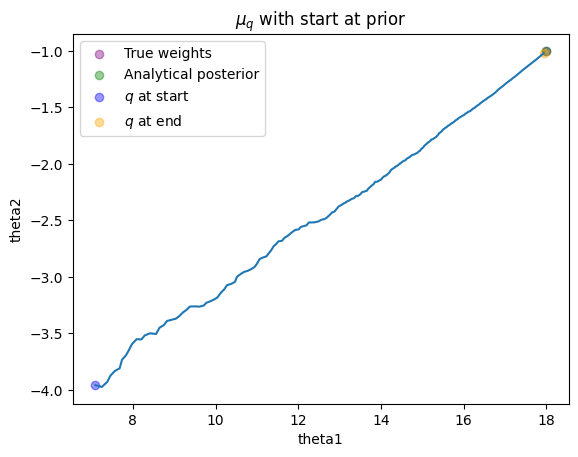

In [257]:
qsa = np.array(qs)
plt.plot(qsa[:, 0], qsa[:,1])
analytical_theta = get_analytical_theta(augment_d(d), y)
plt.scatter(true_weights[0], true_weights[1], color="purple", label="True weights", alpha=0.4)
plt.scatter(analytical_theta[0][0], analytical_theta[0][1], color="green", label="Analytical posterior", alpha=0.4)
plt.scatter(qsa[0,0], qsa[0,1], color="blue", label="$q$ at start", alpha=0.4)
plt.scatter(qsa[-1,0], qsa[-1,1], color="orange", label="$q$ at end", alpha=0.4)
plt.xlabel("theta1")
plt.ylabel("theta2")
plt.title("$\mu_q$ with start at prior")
plt.legend()

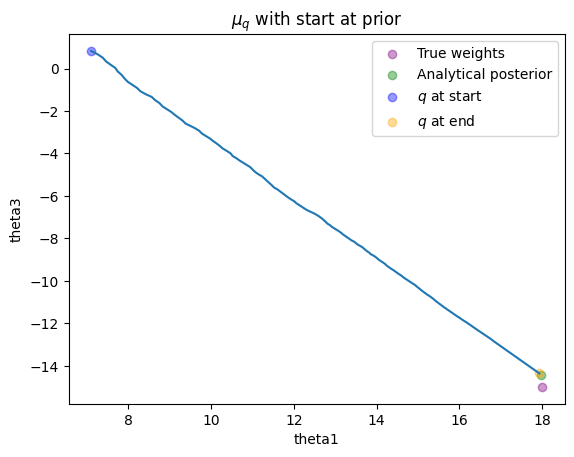

In [258]:
qsa = np.array(qs)
plt.plot(qsa[:, 0], qsa[:,2])
analytical_theta = get_analytical_theta(augment_d(d), y)
plt.scatter(true_weights[0], true_weights[2], color="purple", label="True weights", alpha=0.4)
plt.scatter(analytical_theta[0][0], analytical_theta[0][2], color="green", label="Analytical posterior", alpha=0.4)
plt.scatter(qsa[0,0], qsa[0,2], color="blue", label="$q$ at start", alpha=0.4)
plt.scatter(qsa[-1,0], qsa[-1,2], color="orange", label="$q$ at end", alpha=0.4)
plt.xlabel("theta1")
plt.ylabel("theta3")
plt.title("$\mu_q$ with start at prior")
plt.legend()

Text(0, 0.5, 'ELBO')

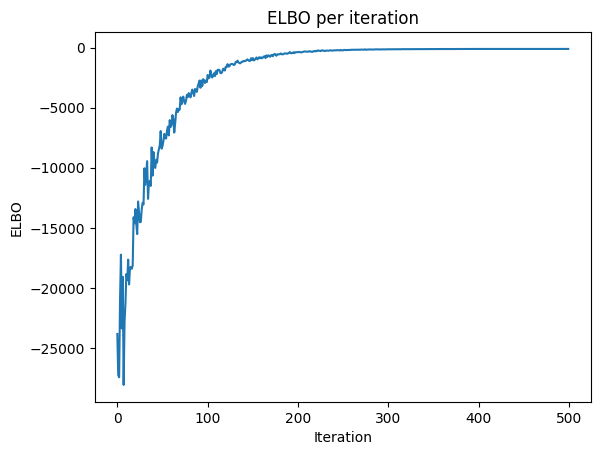

In [259]:
plt.title("ELBO per iteration")
plt.plot(np.arange(0, len(elbos)), elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO")

In [204]:
elbos

[inf,
 inf,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]